## Imports

In [1]:
import os, argparse, numpy as np, pandas as pd
import matplotlib.pyplot as plt 
import illustris_python as il
print("Imports Done")

# A useful print fucntion I often use for printing
def tabprint( printme, start = '\t - ', end = '\n' ):
    print( start + printme, end = end )

Imports Done


---
## Command Line Arguments

This is written in JupyterLab, but will eventually be compiled and ran in python for faster results.  This will define the possible input command line arguements

In [2]:
# This argument decides if code is in python or jupyter.
buildEnv = False

# Define argument parser function 
def initParser():
    
    parser = argparse.ArgumentParser()
    
    parser.add_argument( '-s', '--simDir', default = '../sims.TNG/TNG100-1/output/',  type=str, \
                        help="Base directory for a single simulation on the IllustrisTNG servers.")   
    
    parser.add_argument( '-n', '--simName', default = 'TNG100-1',  type=str, \
                        help="Name for the simulation being worked on.")
    
    parser.add_argument( '-o', '--overwrite', default = False,  type=bool, \
                        help="Overwrite output files?  If false, will check if output file exists before beginning time-consuming tasks.")
    
    parser.add_argument( '-t', '--trim', default = -1,  type=int, \
                        help="Default number of subhalos to consider, sorted by highest mass first.")
    
    parser.add_argument( '-f', '--function', default = 'None', type=str, \
                        help="Default function program will be executing.")

    return parser

parser = initParser()
print("Args: Defined")

Args: Defined


## To Python? Or to JupyterLab? 
This will establish if this is being run in a JupyterLab environment or from Command Line in Python. 

NOTE:  If you're running this in Jupyter, modify the `cmdStr` below to whatever variable you need.

In [3]:
# Am I in a jupyter notebook?
try:
    
    # This command is NOT available in a python script
    get_ipython().__class__.__name__
    buildEnv = True
    print ("In Building Environment")
    
    # Command Line Arguments
    cmdStr  = 'python3 basic-working.py'
    cmdStr += ' --simDir ../sims.TNG/TNG100-1/output/'
    cmdStr += ' --simName TNG100-1'
    cmdStr += ' --trim 10'
    
    # Read string as if command line
    print( "CMD Line: \n\t$:", cmdStr)
    
    # This function doesn't like the 'python3 file.py' part.
    args = parser.parse_args(cmdStr.split()[2:])

# Or am I in a python script?
except:
    
    # Read CMD arguments
    args = parser.parse_args()
    

print( "Args: Read")
print( args )

In Building Environment
CMD Line: 
	$: python3 basic-working.py --simDir ../sims.TNG/TNG100-1/output/ --simName TNG100-1 --trim 10
Args: Read
Namespace(simDir='../sims.TNG/TNG100-1/output/', simName='TNG100-1', overwrite=False, trim=10, function='None')


In [4]:
if buildEnv: 
    # Location of one simulation
    print("Is this locational valid?")
    print( f"Simulation data: {os.path.exists( args.simDir )} - {args.simDir}" )

Is this locational valid?
Simulation data: True - ../sims.TNG/TNG100-1/output/


---
# Halos and SubHalos
Within the simulation, Halos are the largest set of objects that are gravitationally bound to each other, I like to think of them as galaxy clusters.  Subhalos are also gravitationally bound objects but more dense.  I like to think of them as galaxies, globular clusters, etc.

___
# Centrals and Satellites
Halo's often have a singular central galaxy that's the largest, with smaller subhalos orbiting it called satellites.  For our purposes, we will be focusing on the central galaxies because they are the largest and have most likley undergone the most mergers. Let's get a list of subhalo IDs for the central galaxies.

Note 1: The ID is an index for another list.

Note 2: The Halos are ordered by largest mass first.

Note 3: The jump between subhalo id's between halos tells us how many subhalos the halo has. 

In [5]:
def getCentralIds( args, snapshot = 99 ):
    
    cLoc = f'{args.simName}-final-central-galaxies.txt'

    # If already obtained, read from file
    if os.path.exists( cLoc ) and not args.overwrite:
        print(f"Reading Central Galaxy ID file: {cLoc}")
        central_ids = np.loadtxt( cLoc, skiprows=1, dtype=int )

    # Else, use IllustricTNG to get central IDs
    else:
        print(f"Getting Central SubHalo IDs for sim: {args.simName}")
        
        # The GroupFirstSub is the subhalo id for the largest subhalo in a halo.  
        GroupFirstSub = il.groupcat.loadHalos( args.simDir, snapshot, fields=['GroupFirstSub'])
        
        # Filter out groups that contain no subhalos.
        w = np.where(GroupFirstSub >= 0) # value of -1 indicates no subhalo in this group
        central_ids = GroupFirstSub[w]
        
        print( f"Writing Central IDs to file: {cLoc}" )

        cFile = open( cLoc, 'w' )
        cFile.write("SubHaloID \n")
        for c in central_ids:
            cFile.write(f"{c} \n")
        cFile.close()

        tabprint("Writing Complete")
    
    # Trim some from the bottom, after saving all the 
    if args.trim != -1 and central_ids.shape[0] > args.trim:
        central_ids = central_ids[0:args.trim]
        
    return central_ids


if buildEnv and True: 

    central_ids = getCentralIds( args, snapshot=98 )

    print( f'Galactic Cluster Count: {central_ids.shape}' )
    print( f'Top 10 IDs: {central_ids[0:10]}' )
    
elif args.function == 'central-ids':
        central_ids = getCentralIds( args )

Reading Central Galaxy ID file: TNG100-1-final-central-galaxies.txt
Galactic Cluster Count: (10,)
Top 10 IDs: [    0 17185 31342 41582 52618 60731 69507 76086 83280 88663]


# Counting Significant Merger events
We are specifically looking for major and minor mergers, where the secondary galaxy has a significant fraction of mass compared to the primary galaxy.  Let's define a ratio and look for mergers where the secondary galaxy needs at least that much mass in comparison to the primary galaxy.  

Note: The following built in function tells us *how many* they've undergone, but not *when* they've undergone merger events.  But this could still be useful. Since we have 3 Million central galaxies to choose from, it might be useful to find galaxies that have undergone several mergers.  

In [9]:
def getMergerCount( central_ids, args, ratio=0.1 ):
    
    # Check if file exists
    if args.trim == -1:
        fLoc = f'{args.simName}-merger-count.txt'
    else:
        fLoc = f'{args.simName}-merger-count-{args.trim}.txt'

    # If already obtained, read from file
    if os.path.exists( fLoc ) and not args.overwrite:
        print(f"Reading Merger Count file: {fLoc}")
        merger_count_merged = np.loadtxt( fLoc, skiprows=1, dtype=int )
        
        return merger_count_merged

    # Else, use IllustricTNG to get Merger Count
    else:    
    
        # the following fields are required for the walk and the mass ratio analysis
        fields = ['SubhaloID','NextProgenitorID','MainLeafProgenitorID','FirstProgenitorID','SubhaloMassType']
        
        n = central_ids.shape[0]
        merger_count = np.zeros( n, dtype=int )

        for i, id in enumerate( central_ids ):

            # Get merger tree
            tree = il.sublink.loadTree( args.simDir, 99, id, fields=fields )
            
            # Pass merger tree into function to count mergers above ratio threshold
            merger_count[i] = il.sublink.numMergers( tree, minMassRatio=ratio )

            print( f"\t - {i} - {id} - {merger_count[i]} - ", end='\r' )
        
        print( f"\nWriting Merger Count to file: {fLoc}" )

        oFile = open( fLoc, 'w' )
        oFile.write(f"SubHaloID Merger-Count-{ratio}\n")
        for i in range( n ):
            oFile.write(f"{central_ids[i]} {merger_count[i]}\n")
        oFile.close()

        tabprint("Writing Complete")
        
        return merger_count
    
    
    

if buildEnv and True:
    args.trim = 10
    args.overwrite = True
    central_ids = getCentralIds( args )    
    merger_count = getMergerCount( central_ids, args )
    print( f'Merger Count: {merger_count[0:10]}' )
    args.overwrite = False
    

# In python script
elif args.function == 'merger-count':    
    central_ids = getCentralIds( args )
    getMergerCount( central_ids, args )

Getting Central SubHalo IDs for sim: TNG100-1
Writing Central IDs to file: TNG100-1-final-central-galaxies.txt
	 - Writing Complete


KeyError: 0

In [12]:

# Get merger tree
tree = il.sublink.loadTree( args.simDir, 99, central_ids[9] )
print( type( tree ) )

<class 'dict'>


In [15]:
print( tree.keys() )
print( len( tree['DescendantID'] ) )

dict_keys(['count', 'DescendantID', 'FirstProgenitorID', 'FirstSubhaloInFOFGroupID', 'GroupBHMass', 'GroupBHMdot', 'GroupCM', 'GroupFirstSub', 'GroupGasMetalFractions', 'GroupGasMetallicity', 'GroupLen', 'GroupLenType', 'GroupMass', 'GroupMassType', 'GroupNsubs', 'GroupPos', 'GroupSFR', 'GroupStarMetalFractions', 'GroupStarMetallicity', 'GroupVel', 'GroupWindMass', 'Group_M_Crit200', 'Group_M_Crit500', 'Group_M_Mean200', 'Group_M_TopHat200', 'Group_R_Crit200', 'Group_R_Crit500', 'Group_R_Mean200', 'Group_R_TopHat200', 'LastProgenitorID', 'MainLeafProgenitorID', 'Mass', 'MassHistory', 'NextProgenitorID', 'NextSubhaloInFOFGroupID', 'NumParticles', 'RootDescendantID', 'SnapNum', 'SubfindID', 'SubhaloBHMass', 'SubhaloBHMdot', 'SubhaloBfldDisk', 'SubhaloBfldHalo', 'SubhaloCM', 'SubhaloGasMetalFractions', 'SubhaloGasMetalFractionsHalfRad', 'SubhaloGasMetalFractionsMaxRad', 'SubhaloGasMetalFractionsSfr', 'SubhaloGasMetalFractionsSfrWeighted', 'SubhaloGasMetallicity', 'SubhaloGasMetallicityHal

# Going down the Merger Tree

## Understanding Trees as lists

So I had a crash course in how trees can be represented as lists. Here are some of my key findings while trying to udnerstand the Tree. 

- This is a Tree, flattened into a list. 
- Index 0 is the root of the tree.  The original SubHaloID I fed into the loadTree function. 
- A single galaxy will have multiple SubHaloIDs, a seperate ID for each snapshot.
- FirstProgenitorID: ID for this galaxy during the previous snapshot.  -1 if child node.
- NextProgenitorID: Current galaxy will merge with this galaxy by the next snapshot.  -1 if no secondary galaxy.
    - NOTE: If NextProgenitorID has a NextProgenitorID, then 3 or more subhalos were involved.
    - NOTE: Despite the names first/next progenitor, they exist in different snapshots.  
    - FirstProgentitor is a parent to the current progenitor.
    - NextProgenitor and Current Subhalo are the parents for their DescendantID.  
    - Or, if you're looking at the current SubHaloID, if the FirstProgenitor has a NextProgentitor, those two are it's primary and secondary parents.  
- SubhaloMassType, SubhaloMass:  These are NOT sublink.Tree fields.  This implies the tree used the SubhaloID and queried the Group Catalog for additional subhalo info.  Helpful.
- SubhaloIDRaw = SnapNum*10^12 + SubfindID

In [16]:
def find_major_mergers_for_subhalo( subhalo_id, args, cutoff_ratio=0.1, snapshot=99 ):
    """
    Find major mergers for a given subhalo ID based on a specified mass ratio.
    Returns:
    list of dicts containing child, primary, and secondary parent information.
    
    NOTE:   This only follows the two largest galaxies if a major merger is detected.  \
            Does not follow secondary or other parents that are less than 1/10 of child mass.

    """
    # Fields to load from the merger tree
    #fields = ['SubhaloID', 'NextProgenitorID', 'FirstProgenitorID', 'SubhaloMass']
    fields = ['SubhaloID','NextProgenitorID','MainLeafProgenitorID','FirstProgenitorID',\
              'SubhaloIDRaw','SubhaloMass', 'RootDescendantID', 'SnapNum', 'DescendantID']

    # Load the merger tree
    tree = il.sublink.loadTree( args.simDir, snapshot, subhalo_id, fields=fields)
    
    # Create a dictionary to map Subhalo IDs to their index in the list
    subhalo_index = {subhalo_id: index for index, subhalo_id in enumerate(tree['SubhaloID'])} 
    
    # List to store major mergers
    major_mergers = []
    
    # Create queue of index values to work way through.  Add root index of 0.
    queue = [ 0 ] 
    i = 0  # Keep track of visited nodes

    # Traverse the tree
    while len( queue ) > 0:
        
        # Get current index of note
        ci = queue.pop(0)
        i+= 1
                
        # Get primary and secondary ids
        pi = subhalo_index.get( tree['FirstProgenitorID'][ci], -1 )
        si = subhalo_index.get( tree['NextProgenitorID'][pi], -1 )
        
        # If FirstProgenitorID is -1, then you've reached a leaf node. 
        if pi == -1:  continue        
        # else add, primary to queue
        else: queue.append( pi )
        
        # If Secardy parent exists, add to queue. 
        # if si != -1:  queue.append( si )
        
        
        # If secondary galaxy exists, check if mass ratio is great enough for a major merger
        if si != -1:
            primary_mass = tree['SubhaloMass'][pi]
            secondary_mass = tree['SubhaloMass'][si]
            merger_ratio = secondary_mass / ( primary_mass + secondary_mass )

            # If great enough, grab info and append
            if merger_ratio >= cutoff_ratio:
                
                # Add secondary id to queue
                queue.append( si )
                
                merger_info = {}
                
                merger_info['root-SubHaloID'] = subhalo_id
                merger_info['merger-ratio'] = merger_ratio
                
                # Get info for final child, primary and secondary parents. 
                for j, name in [ (ci,'child'), (pi,'primary'), (si,'secondary') ]:
                    
                    merger_info[f'{name}-SubhaloIDRaw'] = tree['SubhaloIDRaw'][j]
                    merger_info[f'{name}-SnapNum']      = tree['SnapNum'][j]
                    merger_info[f'{name}-SubhaloID']    = tree['SubhaloID'][j]
                    merger_info[f'{name}-SubhaloMass']  = tree['SubhaloMass'][j]
                    merger_info[f'{name}-DescendantID']  = tree['DescendantID'][j]
                
                major_mergers.append( merger_info )
                
                
        # end major merger
        
    # End looping queue
    # print(f"Root ID: {subhalo_id} - Found {len(major_mergers)} mergers - Visited {i} nodes. ")
    return major_mergers


def getMajorMergers( central_ids, args, ratio=0.1 ):
    
    import pandas as pd

    # Check if file exists
    if args.trim == -1:
        fLoc = f'{args.simName}-merger-events.csv'
    else:
        fLoc = f'{args.simName}-merger-events-{args.trim}.csv'

    # If already obtained, read from file
    if os.path.exists( fLoc ) and not args.overwrite:
        print(f"Reading File: {fLoc}")
        merger_events = pd.read_csv( fLoc )
        return merger_events
    
    # Else, create file
    
    print( f"Searching for Mergers for {central_ids.shape[0]} Root Galaxies" )
    merger_events = []
    for i, cid in enumerate(central_ids):
        print( f"\t - {i} - {cid}", end='\r')
        merger_events += find_major_mergers_for_subhalo( cid, args ) 
        
    print("\nFinding Mergers Complete")
    
    print( f"Saving Mergers to file: {fLoc}")
    df = pd.DataFrame.from_dict( merger_events )    
    df.to_csv( fLoc, index = False )
    
    return df
    
if buildEnv and True:    
    
    central_ids = getCentralIds( args )
    
    ratio = 0.1  # Replace with desired ratio 
    major_mergers = find_major_mergers_for_subhalo( central_ids[1], args )
    
    print( '\nSample Merger info\n' )
    for k in major_mergers[0]:
        print( f"\t - {k} - {major_mergers[0][k]}")
    
    print("\nEnd Sample")
    # print( major_mergers[0] )
    mergers = getMajorMergers( central_ids, args )
    
elif args.function == 'find-mergers':

    central_ids = getCentralIds( args )    
    mergers = getMajorMergers( central_ids, args )

Getting Central SubHalo IDs for sim: TNG100-1
Writing Central IDs to file: TNG100-1-final-central-galaxies.txt
	 - Writing Complete

Sample Merger info

	 - root-SubHaloID - 17185
	 - merger-ratio - 0.10219524055719376
	 - child-SubhaloIDRaw - 7000000003426
	 - child-SnapNum - 7
	 - child-SubhaloID - 4515263
	 - child-SubhaloMass - 2.744853973388672
	 - child-DescendantID - 4515262
	 - primary-SubhaloIDRaw - 6000000002872
	 - primary-SnapNum - 6
	 - primary-SubhaloID - 4515264
	 - primary-SubhaloMass - 1.5854688882827759
	 - primary-DescendantID - 4515263
	 - secondary-SubhaloIDRaw - 6000000002875
	 - secondary-SnapNum - 6
	 - secondary-SubhaloID - 4515289
	 - secondary-SubhaloMass - 0.18047061562538147
	 - secondary-DescendantID - 4515263

End Sample
Searching for Mergers for 10 Root Galaxies
	 - 9 - 88663
Finding Mergers Complete
Saving Mergers to file: TNG100-1-merger-events-10.csv


# Getting SubHalo Data

Now that we have SubhaloIDs and Snapshot Numbers for the 3 primary galaxies involved with the mergers, let's grab additional information about them elsewhere.  

## Flatten the Retrieved data. 

The data is returned in a nested dictionary.  Using ChatGPT, we wrote a function that will take the nested arrays and create additional columns instead.  

## Loop through merger events and create a row for each galaxy.  

In [17]:
def extractSubhaloFromMerger( mergers ):
    
    # List of subhalo identifiers, requires both SubhaloID and Snap Number. 
    idList = []
    
    # Iterate through dataframe    
    for i in mergers.index:
        
        # Loop through 3 galaxies in each row
        for name in ['child','primary','secondary']:
            
            id_raw = int( mergers[f'{name}-SubhaloIDRaw'][i] )
            
            info = {}
            info['RawID'] = id_raw
            info['SnapNum'] = int( id_raw / 10e11 )
            info['SubhaloID'] = int( id_raw % 10e11 )
            info['SubhaloIDRaw'] = mergers[f'{name}-SubhaloIDRaw'][i]
            info['SubhaloMass'] = mergers[f'{name}-SubhaloMass'][i]
            
            # Extract and append gal infor
            idList.append( info )
    
    return idList


# The following was generated via OpenAI. (2023). ChatGPT [Large language model]. https://chat.openai.com
def flatten_subhalo_data(subhalo_data):
    # Function to flatten specific array fields in the subhalo data dictionary

    def flatten_array(key, labels):
        # Flatten an array field and add individual elements with labels
        array = subhalo_data.get(key)
        if array is not None:
            for i, label in enumerate(labels):
                subhalo_data[f"{key}-{label}"] = array[i]
            del subhalo_data[key]

    # Flatten 3D coordinate fields
    coords = ['X', 'Y', 'Z']
    for field in ['SubhaloCM', 'SubhaloPos', 'SubhaloSpin', 'SubhaloVel']:
        flatten_array(field, coords)

    # Flatten particle type fields
    particle_types = ['GAS', 'DM', 'UNUSED', 'TRACERS', 'STARS_WIND', 'BLACK_HOLES']
    for field in ['SubhaloHalfmassRadType', 'SubhaloMassInHalfRadType', 'SubhaloMassInMaxRadType', 
                  'SubhaloMassInRadType', 'SubhaloMassType', 'SubhaloLenType']:
        flatten_array(field, particle_types)

    # Flatten metal fractions and other 10-element arrays
    elements = ['H', 'He', 'C', 'N', 'O', 'Ne', 'Mg', 'Si', 'Fe', 'Total']
    for field in ['SubhaloGasMetalFractions', 'SubhaloGasMetalFractionsHalfRad', 
                  'SubhaloGasMetalFractionsMaxRad', 'SubhaloGasMetalFractionsSfr', 
                  'SubhaloGasMetalFractionsSfrWeighted', 'SubhaloStarMetalFractions', 
                  'SubhaloStarMetalFractionsHalfRad', 'SubhaloStarMetalFractionsMaxRad']:
        flatten_array(field, elements)

    # Flatten photometric data
    bands = ['U', 'B', 'V', 'K', 'g', 'r', 'i', 'z']
    flatten_array('SubhaloStellarPhotometrics', bands)

    return subhalo_data


def getSubhaloDataFromMergers( args ):

    # Check if file exists
    if args.trim == -1:
        fLoc = f'{args.simName}-subhalo-data.csv'
    else:
        fLoc = f'{args.simName}-subhalo-data-{args.trim}.csv'

    # If already obtained, read from file
    if os.path.exists( fLoc ) and not args.overwrite:
        print(f"Reading File: {fLoc}")
        subhalo_data = pd.read_csv( fLoc )
        return subhalo_data
    
    # Else, create the subhalo table
    
    # Get the starting central IDs and related mergers
    central_ids = getCentralIds( args )
    mergers = getMajorMergers( central_ids, args )

    # Extract subhalo IDs and Snapshot numbers
    subhalo_ids = extractSubhaloFromMerger( mergers )
    subhalo_list = []
    
    # Go through and grab their info
    for i in range( len( subhalo_ids) ):
        sub_info = il.groupcat.loadSingle(args.simDir, subhalo_ids[i]['SnapNum'], subhaloID=subhalo_ids[i]['SubhaloID'])
        
        # flatten 
        flattened_sub_info = flatten_subhalo_data( sub_info )
        flattened_sub_info['SubhaloIDRaw'] = subhalo_ids[i]['SubhaloIDRaw']
        
        subhalo_list.append( flattened_sub_info )
    
    # Done looping through subhalo's
    print("\nRetrieved SubHalo Data")
    
    # Create dataframe out of dictionary.  Save dataframe as csv
    print( f"Saving Subhalo Data to file: {fLoc}")
    
    subhalo_df = pd.DataFrame.from_dict( subhalo_list )    
    subhalo_df.to_csv( fLoc, index = False )
    
    return subhalo_df
        
if buildEnv and True:

    args.overwrite = False
    central_ids = getCentralIds( args )
    mergers = getMajorMergers( central_ids, args )

    # Extract subhalo IDs and Snapshot numbers
    ids = extractSubhaloFromMerger( mergers )
    
    # Go through and grab their info
    i = 0
    sub = il.groupcat.loadSingle(args.simDir, ids[i]['SnapNum'], subhaloID=ids[i]['SubhaloID'])
    
    # Now, let's flatten the dictionary so it can be added to a table. 
    flattened_sub_data = flatten_subhalo_data(sub)
    
    if False:
        for i, k in enumerate(flattened_sub_data):
            print( f"\t - {k}: {flattened_sub_data[k]} ")
            if i > 20: 
                print('...')
                break
    args.overwrite = True
    subhalo_table = getSubhaloDataFromMergers( args )
    
    print('Done')
    

Reading Central Galaxy ID file: TNG100-1-final-central-galaxies.txt
Reading File: TNG100-1-merger-events-10.csv
Getting Central SubHalo IDs for sim: TNG100-1
Writing Central IDs to file: TNG100-1-final-central-galaxies.txt
	 - Writing Complete
Searching for Mergers for 10 Root Galaxies
	 - 9 - 88663
Finding Mergers Complete
Saving Mergers to file: TNG100-1-merger-events-10.csv

Retrieved SubHalo Data
Saving Subhalo Data to file: TNG100-1-subhalo-data-10.csv
Done


In [9]:
## This is a dictionary/json of what all the values are 
subhalo_fields = {
    "SubhaloFlag": {
        "field_name": "SubhaloFlag",
        "datatype": "int16",
        "dimensions": "N",
        "units": "-",
        "description": "Flag field indicating suitability of this subhalo for certain types of analysis. If zero, this subhalo should generally be excluded, and is not thought to be of cosmological origin."
    },
    "SubhaloBHMass": {
        "field_name": "SubhaloBHMass",
        "datatype": "float32",
        "dimensions": "N",
        "units": "10^10 M⊙/h",
        "description": "Sum of the masses of all blackholes in this subhalo."
    },
    "SubhaloBHMdot": {
        "field_name": "SubhaloBHMdot",
        "datatype": "float32",
        "dimensions": "N",
        "units": "(10^10 M⊙/h)/(0.978 Gyr/h)",
        "description": "Sum of the instantaneous accretion rates M˙ of all blackholes in this subhalo."
    },
    "SubhaloBfldDisk": {
        "field_name": "SubhaloBfldDisk",
        "datatype": "float32",
        "dimensions": "N",
        "units": "(h/a^2) (UnitPressure)^1/2",
        "description": "The square root of the volume weighted value of B^2 for all gas cells within the canonical two times the stellar half mass radius."
    },
    "SubhaloBfldHalo": {
        "field_name": "SubhaloBfldHalo",
        "datatype": "float32",
        "dimensions": "N",
        "units": "(h/a^2) (UnitPressure)^1/2",
        "description": "The square root of the volume weighted value of B^2 for all gas cells in the subhalo."
    },
    "SubhaloCM": {
        "field_name": "SubhaloCM",
        "datatype": "float32",
        "dimensions": "N,3",
        "units": "ckpc/h",
        "description": "Comoving center of mass of the Subhalo, computed as the sum of the mass weighted relative coordinates of all particles/cells in the Subhalo, of all types."
    },
    # ... Continue for each field ...
}

In [11]:
# Let's let at galaxy morphologies
import h5py
morphFile = h5py.File('morphologies_deeplearn.hdf5', 'r')

for name in morphFile:
    print( name )

Header
Snapshot_95
Snapshot_99


# Central Masses over time
It is theorized that galaxies typically gain most of their mass through collisions with other galaxies.  Let's plot the mass growing over the simulation snapshots.  Notice the mass growth is on a log scale. Also notice sharp dips in some galaxies.  These dips are likley galaxies currently undergoing merger events, where the missing mass was labeled as belonging to the other galaxy before final collision.  

In [68]:
if buildEnv and False:
    import matplotlib.pyplot as plt 
    fig = plt.figure(figsize=(10,8))
    ax = fig.add_subplot(111)

    fields = ['SubhaloMass','SubfindID','SnapNum']
    start = 99
    for i in range(start, start+5):
        tree = il.sublink.loadTree( args.simDir, 99, central_ids[i], fields=fields, onlyMPB=True)
        mass_msun = tree['SubhaloMass'] * 1e10 / 0.6774
        ax.plot(tree['SnapNum'], mass_msun, '-', label='sub %d' % central_ids[i])

    ax.set_yscale('log')
    ax.set_xlabel('Snapshot Number')
    ax.set_ylabel('Total Subhalo Mass [M$_\odot$]')
    ax.legend();

In [17]:
import sys

!{sys.executable} -m pip install astromartini[tngsource]==2.0.5

In [5]:
import martini
from astropy.io import fits

print('done')

done


In [6]:
from martini import demo

demo()

Source module contained 500 particles with total HI mass of 5.00e+09 solMass.
Pruned particles that will not contribute to data cube, 500 particles remaining with total HI mass of 5.00e+09 solMass.


100%|██████████| 23716/23716 [00:16<00:00, 1427.19it/s]


Source inserted.
  Flux in cube: 2.34e+02 Jy
  Mass in cube (assuming distance 3.00 Mpc): 4.98e+09 solMass
    [100% of initial source mass]
  Maximum pixel: 4.77e-03 Jy / arcsec2
  Median non-zero pixel: 6.75e-09 Jy / arcsec2
Noise added.
  Noise cube RMS: 1.46e-07 Jy / arcsec2 (before beam convolution).
  Data cube RMS after noise addition (before beam convolution): 5.60e-05 Jy / arcsec2
Beam convolved.
  Data cube RMS after beam convolution: 4.48e-02 Jy / beam
  Maximum pixel: 1.93e+00 Jy / beam
  Median non-zero pixel: 2.48e-05 Jy / beam
Wrote demo fits output to testcube.fits, and beam image to testbeam.fits.
Wrote demo hdf5 output to testcube.hdf5.


(32, 128, 128)


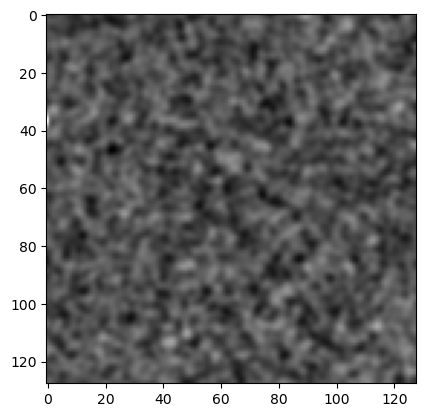

In [20]:
image_data = fits.getdata(image_file)
print( image_data.shape )

plt.imshow(image_data[0], cmap='gray')


In [13]:
from getpass import getpass

api_key = getpass("TNG web API key:")

TNG web API key: ········


In [14]:
simulation = "TNG100-1"
snapshot = 99
subhalo_id = 400547  # a central subhalo with 218 < Vmax < 220, and SFR > 1

In [15]:
from martini.sources import TNGSource
from martini import DataCube, Martini
from martini.beams import GaussianBeam
from martini.noise import GaussianNoise
from martini.spectral_models import GaussianSpectrum
from martini.sph_kernels import CubicSplineKernel
import astropy.units as U

In [16]:
source = TNGSource(
    simulation,
    snapshot,
    subhalo_id,
    api_key=api_key,
    cutout_dir=".",
    distance=4 * U.Mpc,
    rotation={"L_coords": (60 * U.deg, 0.0 * U.deg)},
    ra=0.0 * U.deg,
    dec=0.0 * U.deg,
)

ImportError: cannot import name 'getSnapOffsets' from 'martini.sources._illustris_tools' (/home/tnguser/.local/lib/python3.11/site-packages/martini/sources/_illustris_tools.py)

In [18]:
il.groupcat.

SyntaxError: invalid syntax (1293840873.py, line 1)